<a href="https://colab.research.google.com/github/maryane-castro/SAM/blob/main/Roboflow-tst1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Segment Anything Model (SAM)

---
Notebook do SAM: [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)



## Configurlção do Colab
Para trocar para GPU(recomendação META):

Se você estiver executando este notebook no Google Colab, navegue até `Editar` -> `Configurações do notebook` -> `Acelerador de hardware`, defina-o como `GPU` e clique em `Salvar`. Isso garantirá que seu notebook use uma GPU, o que acelerará significativamente os tempos de treinamento do modelo.




In [ ]:
#só pra ver a versão do CUDA
!nvidia-smi 

Sun Apr 30 21:46:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#importa sistema operacional e pega o caminho do diretório principal (melhorar a navegação)
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Instalação

In [ ]:
#instalar no diretório principal a biblioteca SAM
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ecx_m2dq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ecx_m2dq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=b4cb00a67e979cb4b293fe8a32e51466a15383b1bf532b8673991965740c358f
  Stored in directory: /tmp/pip-ephem-wheel-cache-4807zxc1/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
#instalação da dependencia roboflow para usar nas caixas delimitadora XYWH
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.6 MB/s eta 0:00:00


---
### divisão
---

In [ ]:
#instalação do modelo SAM
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
#combina os caminhos e confere se existe
#caminho HOME/weights/sam_vit_h_4b8939.pth
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
#cria diretório e baixa imagens de exemplo

%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data
#instala as imagens
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://img.elo7.com.br/product/zoom/2A5DF7C/arte-para-encartes-de-supermercados-lojas-etc-propagandas.jpg

/content
/content/data


In [ ]:
#só pra verificar se a gpu é compativel com cuda, definir as variaveis de device o tipo do modelo sam
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   #define o devide como cuda, caso não, usa a cpu
MODEL_TYPE = "vit_h"

In [ ]:
#carrega o modelo
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
#variavel geradora de mascaras
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
#define qual a imagem que vai ser utilizada
import os

IMAGE_NAME = "encarte.jpg"                               #nome da image
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)  #caminho da imagem

#SEGMENTAÇÃO AUTOMATICA
gera todas as mascaras encontradas das imagens

### Gerar a imagem com SAM

In [ ]:
#cv2 para transforma imagem em RGB e supervigion para usar para processamento da imagem
import cv2
import supervision as sv
cv2.imread(IMAGE_PATH)
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  #rgb

sam_result = mask_generator.generate(image_rgb) 

### ANOTAÇÃO SOBRE A MASCARA FORMADA - META prompt

`SamAutomaticMaskGenerator` retorna uma `lista` de máscaras, onde cada máscara é um `dict` contendo várias informações sobre a máscara:

* `segmentation` - `[np.ndarray]` - a máscara com formato `(W, H)` e tipo `bool`
* `area` - `[int]` - a área da máscara em pixels
* `bbox` - `[List[int]]` - a caixa de limite da máscara no formato `xywh`
* `predicted_iou` - `[float]` - a própria previsão do modelo para a qualidade da máscara
* `point_coords` - `[List[List[float]]]` - o ponto de entrada amostrado que gerou esta máscara
* `stability_score` - `[float]` - uma medida adicional da qualidade da máscara
* `crop_box` - `List[int]` - o corte da imagem usado para gerar esta máscara no formato `xywh`

In [ ]:
#só pra mostrar as listas de mascaras
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


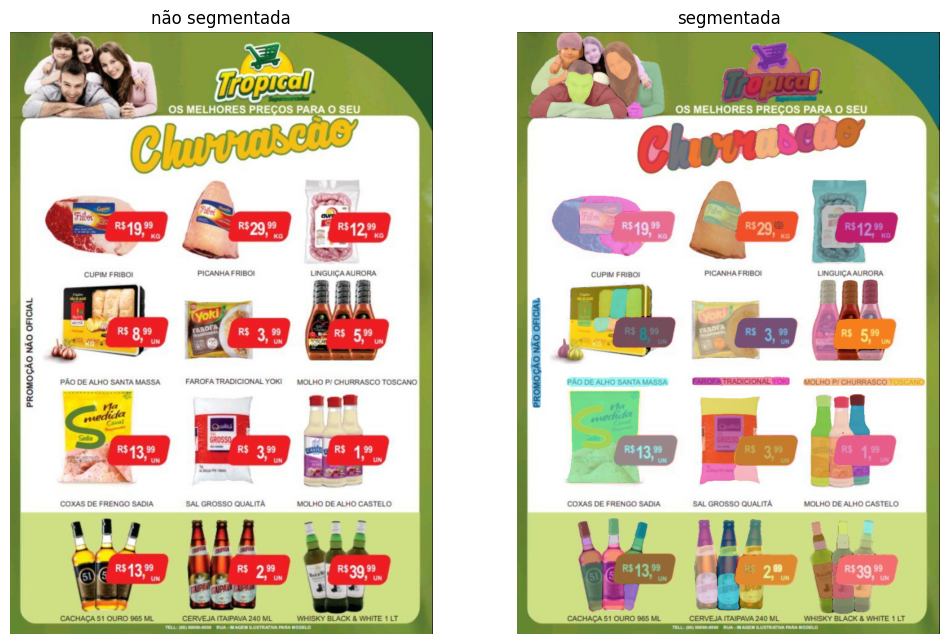

In [ ]:
#suoervision tem suporte nativo ao SAM a partir da versão: 0.5.0

mask_annotator = sv.MaskAnnotator()   #função para mostrar imagens com mascaras

detections = sv.Detections.from_sam(sam_result=sam_result)  #para representar a imagem segmentada

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)  #armazena a imagem segmentada


#imagens que vão ser mostradas, necessita de 3 parametros: imagem(ns), tamanho de linhas e colunas, titulo para cada uma
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['não segmentada', 'segmentada']
)

### PRINT NAS MÁSCARAS 
são geradas em **P&B**

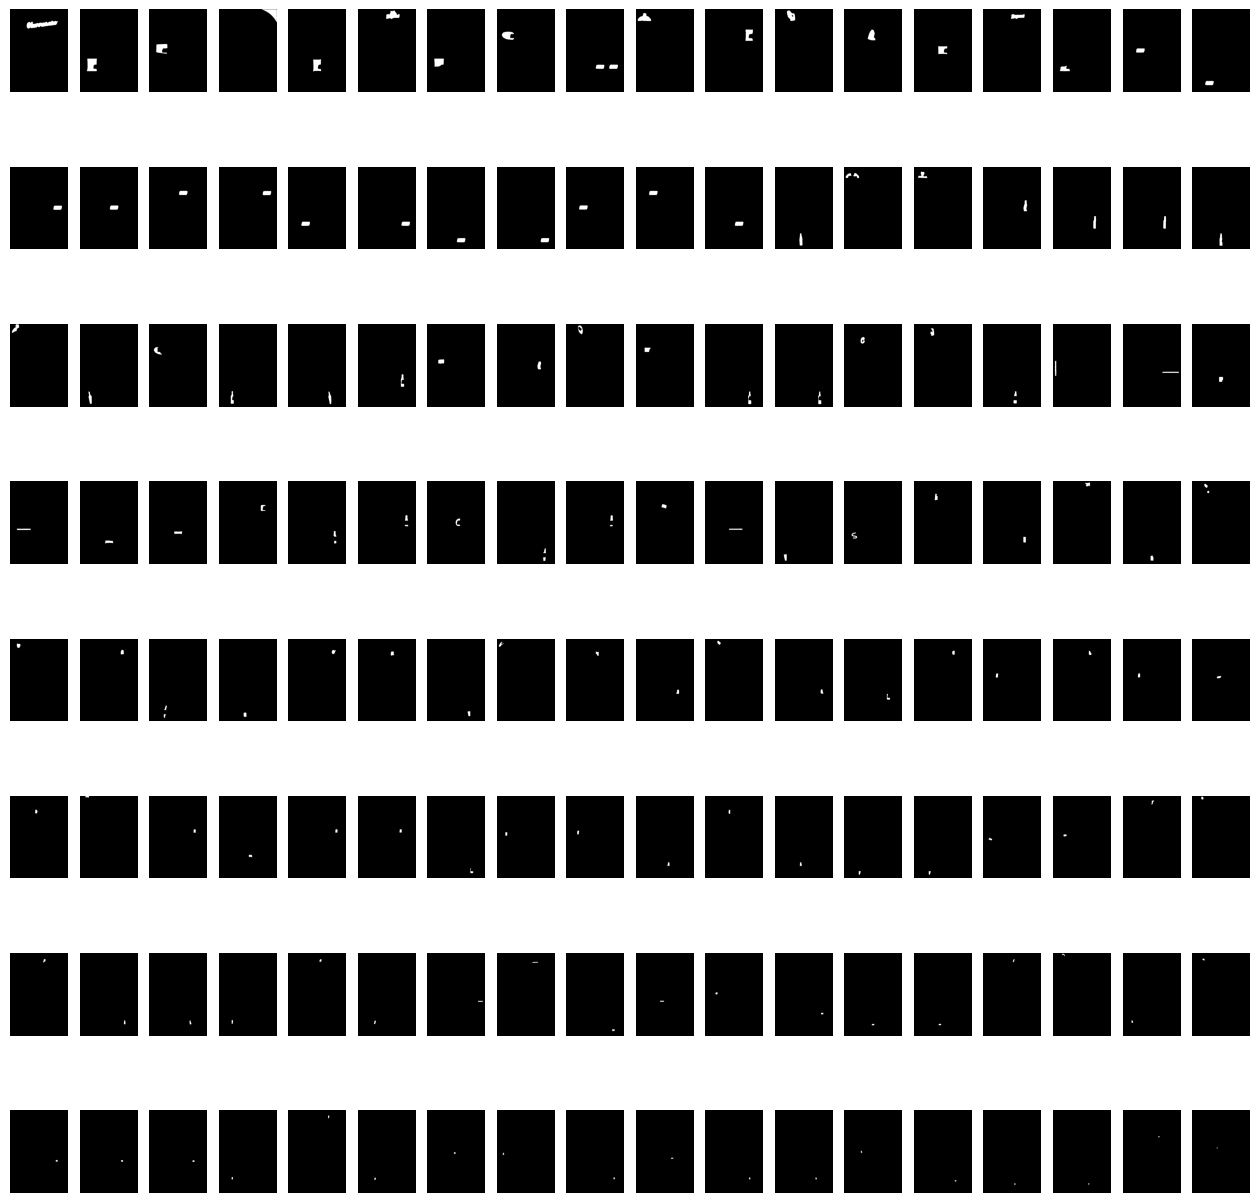

In [ ]:
#lista de mascaras que vão ser ordenadas por ordem de primeira detectação
masks = [
    mask['segmentation']  #escolhendo com qual parte da masks quer trabalhar
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]



#mostrar as mascaras
sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

#SEGMENTAÇÃO MANUAL
##Mais especificas
Para gerar máscaras mais precisas ou em menor quantidade 


##Anotação META
## Gerar segmentação com caixa delimitadora

A classe `SamPredictor` fornece uma interface fácil para o modelo para solicitar o modelo. Ele permite que o usuário primeiro defina uma imagem usando o método `set_image`, que calcula os embeddings de imagem necessários. Em seguida, os prompts podem ser fornecidos por meio do método `predict` para prever com eficiência as máscaras desses prompts. O modelo pode receber como entrada prompts de ponto e caixa, bem como máscaras da iteração anterior de previsão.

In [ ]:
#usado para segmentação manual
mask_predictor = SamPredictor(sam)

In [ ]:
import os

IMAGE_NAME = "encarte.jpg"  #outra imagem
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Atalho para desenhar caixa
####Draw BOX


In [ ]:
# função auxiliar que carrega uma imagem antes de adicioná-la ao widget

import base64
#vai transferir imagem como str, ou seja, texto
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
#aqui desenha a box com mouse, a função é propria do jupyter
#fica mais facil de pegar eixos XYWH

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
#mostra os eixos da caixa
widget.bboxes

[{'x': 92, 'y': 709, 'width': 675, 'height': 195, 'label': ''}]

### Gerar a mascara com predictor

**OBS:** O método `SamPredictor.predict` usa o `np.ndarray` `box` com `[x_min, y_min, x_max, y_max]`

In [ ]:
import numpy as np

# para não dar erro caso não haja nada no box, usa qualquer valor
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

#definindo o xywh_min
box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)           #define imagem do objeto

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True  #diz que em vez de gerar apenas uma mascara, deve gerar várias
)

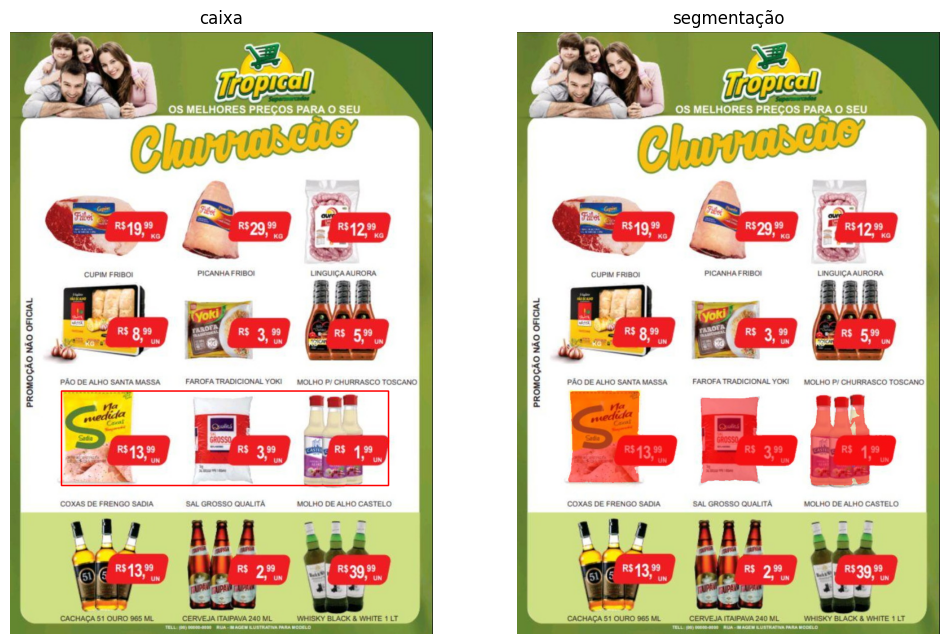

In [ ]:
#visualizar o resultado final


box_annotator = sv.BoxAnnotator(color=sv.Color.red())  #para definir a cor da caixa gerada(box)
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())  #para definir a cor da mascara


#função mask_to_xyxy do supervision
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]



#método annotate do box_annotator e do mask_annotator para adicionar a caixa e a máscara na imagem
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)


#mostrar com o supervision
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['caixa', 'segmentação']
)

### Mostrar as mascaras encontradas

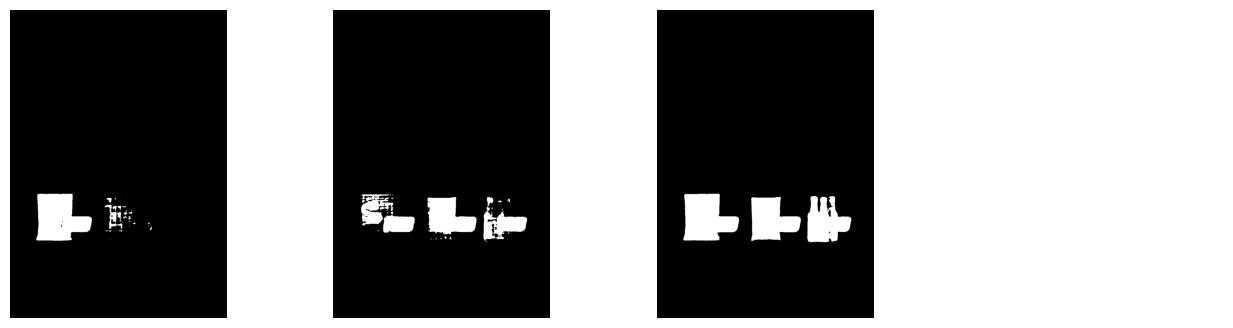

In [ ]:
import supervision as sv

#images recebe todas as mascaras encontadas em P&B
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)



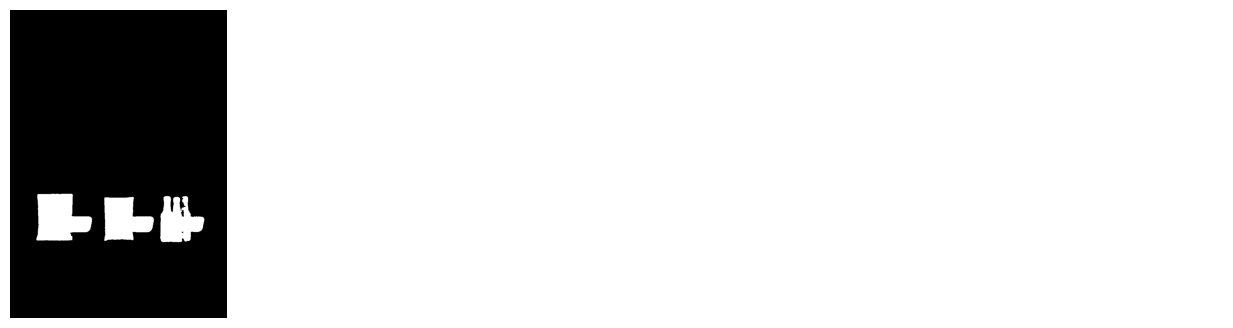

In [ ]:
#printar apenas uma imagem
import supervision as sv

#images recebe todas as mascaras encontadas em P&B
sv.plot_images_grid(
    images=[masks[2]],
    grid_size=(1, 4),
    size=(16, 4)
)
